In [11]:
import numpy as np
import pandas as pd
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [12]:
import yfinance as yf

DX = yf.Ticker("DX-Y.NYB")
raw_data = DX.history(period = 'max')['Close']
raw_data.tail()

Date
2021-08-30    92.650002
2021-08-31    92.629997
2021-09-01    92.449997
2021-09-02    92.230003
2021-09-03    92.105003
Name: Close, dtype: float64

<AxesSubplot:xlabel='Date'>

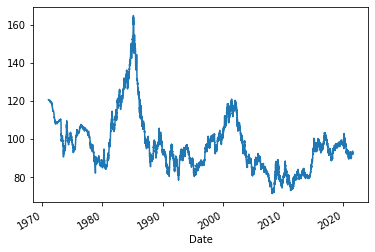

In [13]:
raw_data.plot()

用create_seq將一個時間序列依想要訓練的長度  
拆成訓練資料與target  

In [40]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length ):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [522]:
create_sequences(raw_data.loc['2021'::], 5)
#將每5天抓出來成為一個array 並用第6天的當成收盤價

(array([[89.87999725, 89.44000244, 89.52999878, 89.83000183, 90.09999847],
        [89.44000244, 89.52999878, 89.83000183, 90.09999847, 90.54000092],
        [89.52999878, 89.83000183, 90.09999847, 90.54000092, 90.05000305],
        [89.83000183, 90.09999847, 90.54000092, 90.05000305, 90.31999969],
        [90.09999847, 90.54000092, 90.05000305, 90.31999969, 90.23999786],
        [90.54000092, 90.05000305, 90.31999969, 90.23999786, 90.77999878],
        [90.05000305, 90.31999969, 90.23999786, 90.77999878, 90.5       ],
        [90.31999969, 90.23999786, 90.77999878, 90.5       , 90.47000122],
        [90.23999786, 90.77999878, 90.5       , 90.47000122, 90.12999725],
        [90.77999878, 90.5       , 90.47000122, 90.12999725, 90.23999786],
        [90.5       , 90.47000122, 90.12999725, 90.23999786, 90.38999939],
        [90.47000122, 90.12999725, 90.23999786, 90.38999939, 90.16999817],
        [90.12999725, 90.23999786, 90.38999939, 90.16999817, 90.65000153],
        [90.23999786, 90.

In [189]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [523]:
class DX_dataset(Dataset):
    def __init__(self, data, mode = 'train'):
         
        #set data split
        test_date = '2021'
        start_train = '2010'
        end_train='2020'    
        self.seq_length = config['seq_length']

        self.mode = mode
        
        if self.mode == 'test': #就是test mode的情況下
            x,y = create_sequences(data.loc[test_date], self.seq_length)
            self.data = torch.FloatTensor(x)
            self.test_target = y # 用來評斷test的loss
        else: 
            # create sequence 
            x,y = create_sequences(data.loc[start_train:end_train], self.seq_length)
            
            sub_train_size = round(len(x)*0.8) #train_mode set 80% for training
            if self.mode == 'train':
                self.data = torch.FloatTensor(x[0:sub_train_size])
                self.target = torch.FloatTensor(y[0:sub_train_size])
            elif self.mode == 'vaildation':
                self.data = torch.FloatTensor(x[sub_train_size::])
                self.target = torch.FloatTensor(y[sub_train_size::])
            
            #self.target = \
            #(self.target - self.target.mean(dim=0, keepdim=True)) \
            #/ self.target.std(dim=0, keepdim=True)
        
        self.data = \
            (self.data - self.data.mean(dim=0, keepdim=True)) \
            / self.data.std(dim=0, keepdim=True)
        

    def __getitem__(self, index):
        
        if self.mode in ['train', 'vaildation']:
            # For training
            return self.data[index].view(1,1,self.seq_length), self.target[index]
        else:
            # For testing (no target)
            return self.data[index].view(1,1,self.seq_length)
            
    def __len__(self): 
        # Returns the size of the dataset
        return len(self.data)

In [524]:
def prep_dataloader(data, mode, batch_size, n_jobs=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = DX_dataset(data, mode=mode)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=True,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [503]:
data = prep_dataloader(raw_data, mode= 'test',batch_size = 64)

In [526]:
#用來試試看模型dim是否正確
model = Model(1)
test = torch.randn(1,1,14)
pred = model(test)
pred.shape


torch.Size([1, 1, 1])

In [527]:
#原本自己弄了一個naive的1d cnn 但效果很差 就直接把別人疊好的拿來用
class Conv1dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(5,), stride=(1,), padding=(2,)):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode='replicate', bias=True),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode='replicate', bias=True),
            nn.BatchNorm1d(out_channels),
        )
        self.activation = nn.ReLU()
        
    def forward(self, x):
        output = self.conv_block(x)
        output = self.activation(output)
        return output
    # with kernel_size & padding , can make sure length of output eqauals to input array
    
class Model(nn.Module):
     def __init__(self, in_channels):
        super().__init__()
        self.conv_block1 = Conv1dBlock(in_channels=in_channels, out_channels=32)
        self.conv_block2 = Conv1dBlock(in_channels=32, out_channels=64)
        self.conv_block3 = Conv1dBlock(in_channels=64, out_channels=128)
        self.conv_block4 = Conv1dBlock(in_channels=128, out_channels=64)
        self.conv_block5 = Conv1dBlock(in_channels=64, out_channels=32)
        self.conv_block6 = Conv1dBlock(in_channels=32, out_channels=16)
        self.conv_block7 = Conv1dBlock(in_channels=16, out_channels=8)
        self.conv_block8 = Conv1dBlock(in_channels=8, out_channels=1)
        self.pooling = nn.AvgPool1d(kernel_size=(3,), stride=(1,), padding=(1,))
        self.linear1 = nn.Linear(1 * 14  ,28) #out_dim * seq_length * batch_size
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(28,1)

        self.criterion = nn.MSELoss(reduction='mean')
     
     def forward(self, x):
        x = self.conv_block1(x)
        x = self.pooling(x)
        x = self.conv_block2(x)
        x = self.pooling(x)
        x = self.conv_block3(x)
        x = self.pooling(x)
        x = self.conv_block4(x)
        x = self.pooling(x)
        x = self.conv_block5(x)
        x = self.pooling(x)
        x = self.conv_block6(x)
        x = self.pooling(x)
        x = self.conv_block7(x)
        x = self.pooling(x)
        x = self.conv_block8(x)
        x = self.pooling(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x
    
     def cal_loss(self, pred, target):
        return self.criterion(pred, target)


In [517]:
#直接搬李鴻毅HW1的train過來改
def train(tr_set, dv_set, model, config):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero cleaning grad before
            x = x.view(1,1,config['batch_size']*config['seq_length'])
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            #torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record


def dev(dv_set, model):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        with torch.no_grad():                   # disable gradient calculation
            x = x.view(1,1,config['batch_size']*config['seq_length'])               # reshpae batch vetcor to model(beatch_size * sequece_length) 
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

def test(tt_set, model):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        with torch.no_grad():                   # disable gradient calculation
            x = x.view(1,1,config['seq_length'])
            pred = model(x)                     # forward pass (compute output)
            #pred = pred * x.std() + x.mean()
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds



In [520]:
#optimizer 用Adam
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 1,               # mini-batch size for dataloader
    'seq_length' : 14,
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        #'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200             # early stopping epochs (the number epochs since your model's last improvement) # your model will be saved here
}


# >>>問題點 <<<
假使用14天(or X天)的data去預測明天的收盤價  
batch_size必需設定為1  
不然他會將n筆14天的資料壓成一個vector當作NN的input (這樣input size就不是14， 而是n*14  
而這樣就無法單用14天的資料去預測隔天的(會變成 你餵給他n*14 他給你一個return  
而把batch_size設定為1 train的速度太慢 跑不了  

In [528]:
#train 太慢跑不了 把batch調大雖然可以train 但不是我要的用14天資料去預測隔天
tr_set = prep_dataloader(raw_data, 'train', config['batch_size'])
dv_set = prep_dataloader(raw_data, 'vaildation', config['batch_size'])

model = Model(1)
model_loss, model_loss_record = train(tr_set, dv_set, model, config)

KeyboardInterrupt: 

In [283]:
a = dv_set.dataset.data[10].view(1,1,14)
preds = model(a) 

In [515]:
tt_set = prep_dataloader(raw_data, 'test', config['batch_size'])
preds = test(tt_set, model)

RuntimeError: shape '[1, 1, 14]' is invalid for input of size 896

In [513]:
tt_set.dataset.data.shape

torch.Size([156, 14])

In [511]:
preds

array([[[86.70428]],

       [[99.1722 ]]], dtype=float32)

In [512]:
result = pd.DataFrame(preds)
result.plot()

ValueError: Must pass 2-d input. shape=(2, 1, 1)

<AxesSubplot:xlabel='Date'>

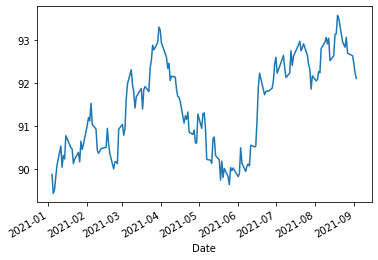

In [313]:
raw_data.loc['2021'].plot()